# titanic生存者予測

参考URL: https://www.kaggle.com/omarelgabry/a-journey-through-titanic

## Flow

1. データセット欠損箇所チェック  
2. 欠損箇所埋め及びOne-Hot表現へ変換
3. 大欠損・不要カラム削除
4. 学習
5. CSV生成

## 学習したこと

1. 全て数字変換する必要がある
2. 前処理が全て

## imports

In [151]:
# pandas
import pandas as pd
from pandas import Series, DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## データセット読み込み

訓練データでは
Age, Cabin, Embarked
テストデータでは
Age, Fare, Cabin
の欠損がみられるのでこれらを補間していく必要がある

In [152]:
titanic_df = pd.read_csv('datasets/train.csv')
test_df    = pd.read_csv('datasets/test.csv')

# datainfo
print(titanic_df.info())
print('----------------------------')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object

## カラムの補間及び削除

必要のないカラムは削除する  
必要なカラムで値に抜けがあるなら補間  
列ごとの操作ならaxis=0  
行ごとの操作ならaxis=1  
今回は行ごと消すのでaxis=1

In [153]:
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df    = test_df.drop(['Name','Ticket'], axis=1)

### Embarked

訓練用データに限って2件欠損している  
Embarkedは搭乗位置を指す(S:Southampton、C:Cherbourg、Q:Queenstown)  
現状のデータ構成をプロットする

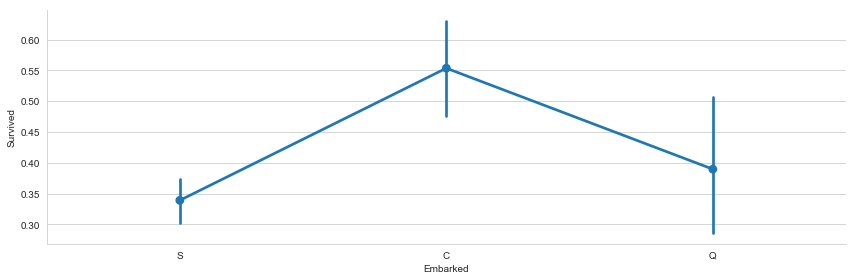

In [154]:
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")
sns.factorplot('Embarked','Survived', data=titanic_df,size=4,aspect=3)

欠損箇所はSで補間する  
一番影響の薄そうな場所がベスト

embarkはS,C,Qで表現されているが文字列のままだと分類できないので  
Ont-Hot表現に変換する

In [155]:
#One-Hot表現に変換済みの変数をダミー変数という
embark_dummies_titanic  = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

titanic_df = titanic_df.join(embark_dummies_titanic)
test_df    = test_df.join(embark_dummies_test)

titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

### Fare

テストデータに限って欠損がみられるので  
欠損を中央値で埋める

In [156]:
# fillnaで欠損箇所に中央値を挿入 inplaceで元データへ反映
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# float型をint型に変更
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare'] = test_df['Fare'].astype(int)

### Age

In [157]:
# ageのNaN数
print(titanic_df['Age'].isnull().sum())

177


In [158]:
# 中央値で補完してみる
titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)
print(titanic_df['Age'].isnull().sum())
print(test_df['Age'].isnull().sum())

0
0


### Cabin

cabinに関しては極めて欠損値が多いためDrop

In [159]:
titanic_df.drop("Cabin", axis=1, inplace=True)
test_df.drop("Cabin", axis=1, inplace=True)

### Family

家族情報に関してはParchとSibSpがあるのでFamilyという一つのカラムにまとめる

In [160]:
# Familyにまとめる
titanic_df['Family'] =  titanic_df["Parch"] + titanic_df["SibSp"]
# 一人できたか、家族できたかで分別
titanic_df['Family'].loc[titanic_df['Family'] > 0] = 1
titanic_df['Family'].loc[titanic_df['Family'] == 0] = 0

test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0

/Users/zen/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Sex

男性、女性、子供でクラス分け  
新たにPersonカラムを用意

In [161]:
# Age      22
# Sex    male
# Name: 0, dtype: object
# の形状で取得できる
def get_person(passenger):
    age, sex = passenger
    return 'child' if age < 16 else sex

# apply: 行や列ごとにまとめて関数を適応してくれる関数
# arg1: 適応したい関数
# arg2: 0:列数と同サイズ 1:行数と同サイズ
titanic_df['Person'] = titanic_df[['Age', 'Sex']].apply(get_person, axis=1)
test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

print(titanic_df['Person'].head(10))

# 不要になるSexカラムは削除
titanic_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

0      male
1    female
2    female
3    female
4      male
5      male
6      male
7     child
8    female
9     child
Name: Person, dtype: object


上記のようにクラス分けに成功!  
続いて不要になったカラムの削除等々を行う

In [162]:
# 現状だとPersonの中身はmale,female,childの文字列のため、これらをダミー変数へ変換する
# ダミー変数とはいわゆるOne-Hotベクトルを指す
person_dummies_titanic = pd.get_dummies(titanic_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

titanic_df = titanic_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)

titanic_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

### Pclass

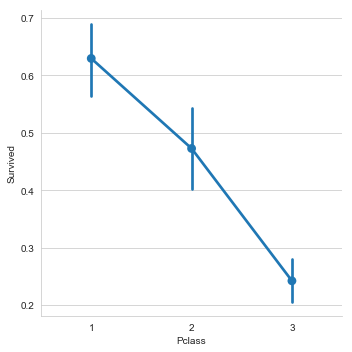

In [163]:
sns.factorplot('Pclass','Survived',order=[1,2,3], data=titanic_df,size=5)

グラフをみる限りPclass3の座席の方がめっちゃ亡くなってる

In [164]:
pclass_dummies_titanic  = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

titanic_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

titanic_df = titanic_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

## 訓練データとテストデータ定義

In [165]:
print(titanic_df.info())
# Xには各種特徴 Yには生存したかどうかを格納する
X_train = titanic_df.drop("Survived",axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived    891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null int64
C           891 non-null float64
Q           891 non-null float64
Family      891 non-null int64
Child       891 non-null float64
Female      891 non-null float64
Class_1     891 non-null float64
Class_2     891 non-null float64
dtypes: float64(7), int64(5)
memory usage: 83.6 KB
None


## 学習開始

In [172]:
# 扱っているデータが全て数字だけとわかる
print(X_train.head(5))
print(Y_train.head(5))

#　ランダムフォレストインスタンス生成
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

# 上で作ったモデルを使ってテストデータを分類 出力された生存可否を変数へ代入
Y_pred = random_forest.predict(X_test)

# できた学習モデルに訓練データを当てて、訓練データの場合の正答率を出力
random_forest.score(X_train, Y_train)

    Age  SibSp  Parch  Fare    C    Q  Family  Child  Female  Class_1  Class_2
0  22.0      1      0     7  0.0  0.0       1    0.0     0.0      0.0      0.0
1  38.0      1      0    71  1.0  0.0       1    0.0     1.0      1.0      0.0
2  26.0      0      0     7  0.0  0.0       0    0.0     1.0      0.0      0.0
3  35.0      1      0    53  0.0  0.0       1    0.0     1.0      1.0      0.0
4  35.0      0      0     8  0.0  0.0       0    0.0     0.0      0.0      0.0
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


0.96184062850729513

## 提出用CSV形成

In [170]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)